A placeholder notebook for running analysis requiring R libraries while the `rpy2` library isn't loading successfully.

First, we install all the necessary packages we need.

In [17]:
suppressPackageStartupMessages(library(factoextra))
suppressPackageStartupMessages(library(mclust))
suppressPackageStartupMessages(library(dplyr))

### Should Clustering be Applied?
First load the DataFrame to be used for clustering

**Summarising the DataFrame in one stat is not exhaustive, particularly for datasets with large values. Better answer to this question comes from evaluation and interpretation. The easier the interpretation**

[1] "Hopkins statistic: 0.837481263062538"

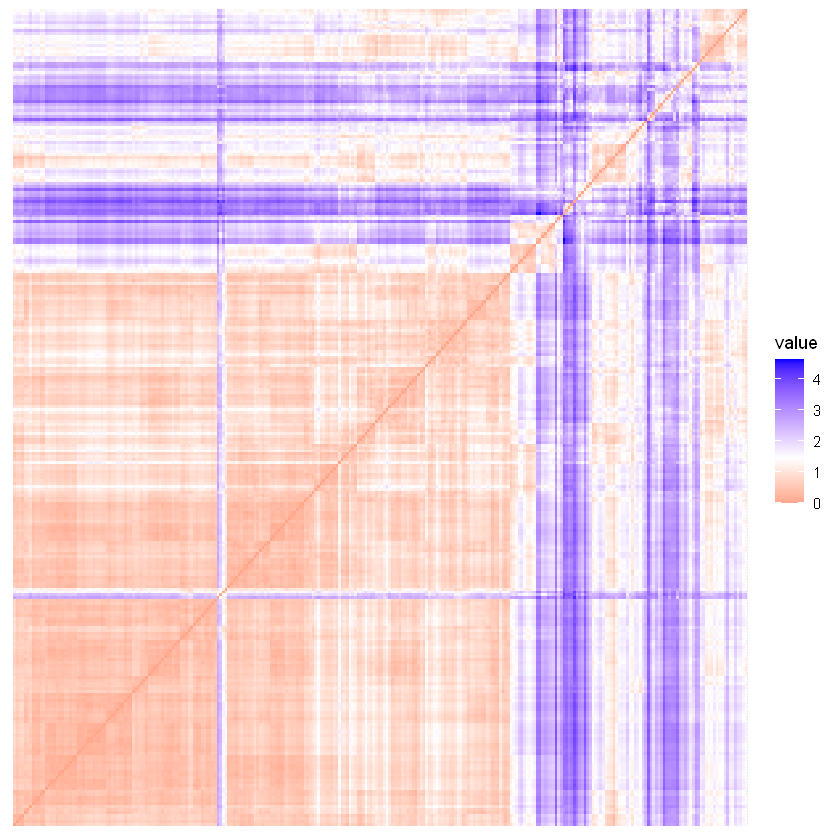

In [18]:
non_zero_median_times_per_stage_df <- read.csv("data/temp/non_zero_median_times_per_stage_df.csv", row.names = "exercise_log_id")
clustering_tendency <- get_clust_tendency(non_zero_median_times_per_stage_df, n = nrow(non_zero_median_times_per_stage_df) - 1)
paste("Hopkins statistic:", clustering_tendency$hopkins_stat)
clustering_tendency$plot

### Evaluating Models' Internal Quality

**Feedback: Generally, don't try to quantify a whole model by one number; multiple metrics give more context. K-means seem to generally have low ASW values. Some other approaches to try: mixture regression, `mclust` (available in Python)**

In [8]:
source("calculate_clustering_metrics.r")

k3_means_final_model_labels_df <- read.csv("data/temp/k3_means_final_model_labels.csv", row.names = 1)
k3_means_final_model_labels <- k3_means_final_model_labels_df[rownames(non_zero_median_times_per_stage_df), , drop = FALSE][,1]
k3_means_final_model_metrics <- calculate_cluster_evaluation_metrics(non_zero_median_times_per_stage_df, k3_means_final_model_labels)
cat("K-Means (K=3) Final Model Metrics:\n")
for (metric_name in names(k3_means_final_model_metrics)) {
    cat(metric_name, ":", k3_means_final_model_metrics[[metric_name]], "\n")
}

k4_means_final_model_labels_df <- read.csv("data/temp/k4_means_final_model_labels.csv", row.names = 1)
k4_means_final_model_labels <- k4_means_final_model_labels_df[rownames(non_zero_median_times_per_stage_df), , drop = FALSE][,1]
k4_means_final_model_metrics <- calculate_cluster_evaluation_metrics(non_zero_median_times_per_stage_df, k4_means_final_model_labels)
cat("K-Means (K=4) Final Model Metrics:\n")
for (metric_name in names(k4_means_final_model_metrics)) {
    cat(metric_name, ":", k4_means_final_model_metrics[[metric_name]], "\n")
}

ahc_ward_model_labels_df <- read.csv("data/temp/ahc_ward_model_labels.csv", row.names = 1)
ahc_ward_model_labels <- ahc_ward_model_labels_df[rownames(non_zero_median_times_per_stage_df), , drop = FALSE][,1]
ahc_ward_model_metrics <- calculate_cluster_evaluation_metrics(non_zero_median_times_per_stage_df, ahc_ward_model_labels)
cat("\nAHC Ward Model Metrics:\n")
for (metric_name in names(ahc_ward_model_metrics)) {
    cat(metric_name, ":", ahc_ward_model_metrics[[metric_name]], "\n")
}

ahc_complete_linkage_cityblock_labels_df <- read.csv("data/temp/ahc_complete_linkage_cityblock_labels.csv", row.names = 1)
ahc_complete_linkage_cityblock_labels <- ahc_complete_linkage_cityblock_labels_df[rownames(non_zero_median_times_per_stage_df), , drop = FALSE][,1]
ahc_complete_linkage_cityblock_metrics <- calculate_cluster_evaluation_metrics(non_zero_median_times_per_stage_df, ahc_complete_linkage_cityblock_labels, "manhattan")
cat("\nAHC Complete Linkage Cityblock Metrics:\n")
for (metric_name in names(ahc_complete_linkage_cityblock_metrics)) {
    cat(metric_name, ":", ahc_complete_linkage_cityblock_metrics[[metric_name]], "\n")
}

K-Means (K=3) Final Model Metrics:
point_biserial_correlation : 0.6932468 
average_silhouette_width : 0.4314567 
huberts_c : 0.08072664 
K-Means (K=4) Final Model Metrics:
point_biserial_correlation : 0.7185934 
average_silhouette_width : 0.4221111 
huberts_c : 0.05805531 

AHC Ward Model Metrics:
point_biserial_correlation : 0.6800227 
average_silhouette_width : 0.3969331 
huberts_c : 0.08374394 

AHC Complete Linkage Cityblock Metrics:
point_biserial_correlation : 0.6439614 
average_silhouette_width : 0.3500235 
huberts_c : 0.09663831 


### Applying model-based clustering using `mclust`

The `mclust` package offers a huge amount of flexibility in the implementation of model-based clustering. This package was used to perform model-based clustering using a similar procedure to the other models:
1. Investigate the suitability of many different models by plotting their Bayesian Information Criterion (BIC) and Integrated Complete Likelihood (ICL) values (using the `mclustBIC` and `mclustICL` functions respectively).
2. As per the guidelines in Scrucca et al., (2024), the elbow method was used with respect to the BIC and ICL to identify some candidate solutions.

Best BIC values:
             VVI,6      VVI,7     VVI,5
BIC      -379.9974 -406.25641 -439.5242
BIC diff    0.0000  -26.25905  -59.5268

Best ICL values:
             VVI,6      VVI,7      VVI,5
ICL      -440.6007 -475.01004 -497.20469
ICL diff    0.0000  -34.40936  -56.60401

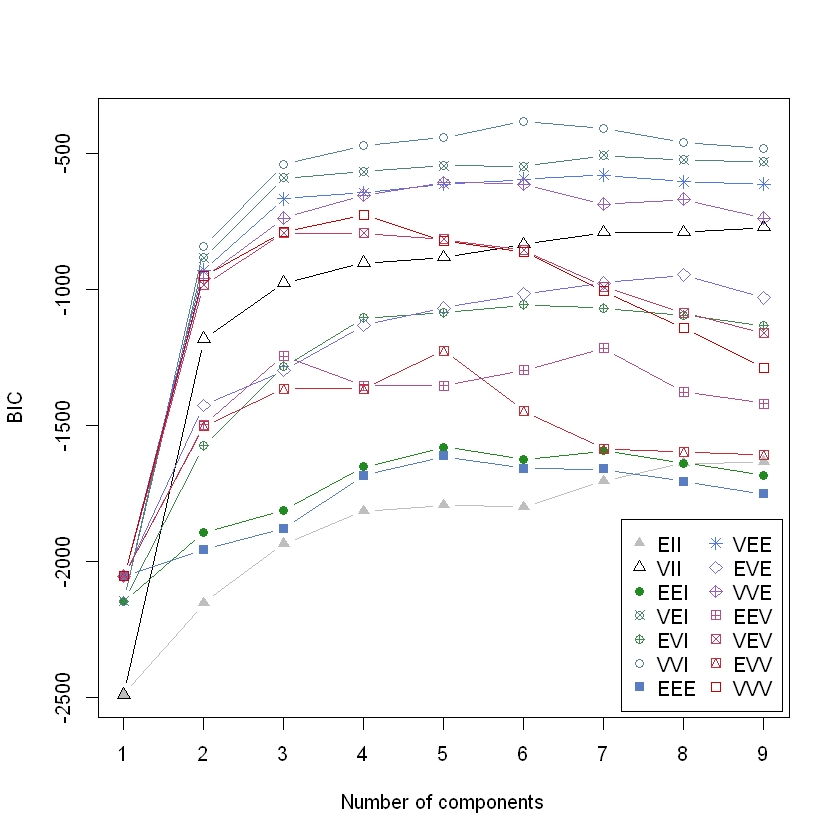

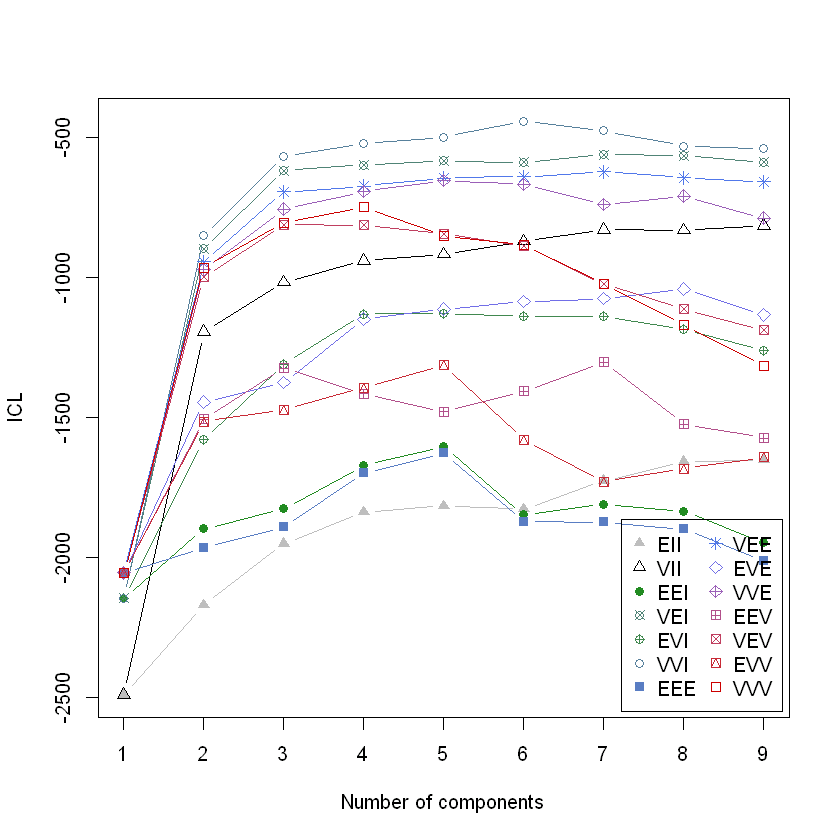

In [19]:
bic_values <- mclustBIC(non_zero_median_times_per_stage_df)
summary(bic_values)
plot(bic_values)

icl_values <- mclustICL(non_zero_median_times_per_stage_df)
summary(icl_values)
plot(icl_values)

The highest BIC and ICL values all come from the `VVI` model with `k` values of 5-7. However, the elbow plot (as well as the investigation of previous clustering models) was used to decide on a value of `k=4`.

In [47]:
g <- 4
model_based_cluster <- Mclust(non_zero_median_times_per_stage_df, modelNames = "VVI", G = g)
summary(model_based_cluster, parameters = TRUE)

---------------------------------------------------- 
Gaussian finite mixture model fitted by EM algorithm 
---------------------------------------------------- 

Mclust VVI (diagonal, varying volume and shape) model with 4 components: 

 log-likelihood   n df       BIC       ICL
      -68.79122 278 59 -469.6121 -521.0728

Clustering table:
 1  2  3  4 
87 85 44 62 

Mixing probabilities:
        1         2         3         4 
0.3198047 0.2910215 0.1624918 0.2266820 

Means:
                                    [,1]       [,2]      [,3]       [,4]
DebuggingStage.predict      -0.258338561 -0.4957703 0.2484285  0.1576580
DebuggingStage.run           0.023904343 -0.2641838 0.2406585 -0.2338298
DebuggingStage.spot_defect   0.004137811 -0.5371520 0.3659140 -0.3340683
DebuggingStage.inspect_code -0.094567596 -0.4807667 0.5778336 -0.2624316
DebuggingStage.find_error   -0.080991850 -0.1754946 0.1216872 -0.1756745
DebuggingStage.fix_error    -0.129009302 -0.2732618 0.2757978 -0.2305821
Debuggi

### Evaluation
Model-based clustering evaluation follows a different pattern to the previous methods used (for now, see `main.ipynb`). As a result, the guidelines in Scrucca et al., (2024) were also used for evaluation. This involved calculating the following for the model:
- Entropy.
- Average entropy of each latent component.
- Average posterior probabilities (AvePP).

In [27]:
probs <- model_based_cluster$z
probs_map <- apply(probs, 1, max)
clusters <- model_based_cluster$classification

entropy_terms <- ifelse(probs > 0, probs * log(probs), 0) #Accounts for log(0) being undefined
total_entropy <- 1 + sum(entropy_terms) / (model_based_cluster$n * log(g))
total_entropy

individual_entropy <- 1 + rowSums(entropy_terms) / log(g)
cluster_entropy_df <- data.frame(cluster = clusters, entropy = individual_entropy) |>
    group_by(cluster)
summarise(cluster_entropy_df,
          count = n(),
          mean_entropy = mean(entropy),
            sd_entropy = sd(entropy),
            min_entropy = min(entropy),
            max_entropy = max(entropy))

mean(probs_map)
avepp_df <- data.frame(cluster = as.factor(clusters), avepp = probs_map) |>
    group_by(cluster)
summarise(avepp_df,
          count = n(),
          mean_avepp = mean(avepp),
          sd_avepp = sd(avepp),
          min_avepp = min(avepp),
          max_avepp = max(avepp))

[1] 0.853187

cluster,count,mean_entropy,sd_entropy,min_entropy,max_entropy
<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,87,0.8630671,0.15289086,0.4971862,0.9964203
2,85,0.8410336,0.18279137,0.2953807,0.9880193
3,44,0.9722150,0.09299932,0.5445263,1.0000000
4,62,0.7715132,0.19964944,0.3470789,0.9999313


[1] 0.9219219

cluster,count,mean_avepp,sd_avepp,min_avepp,max_avepp
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,87,0.9287556,0.1122420,0.5205789,0.9994473
2,85,0.9203753,0.1261160,0.5016928,0.9976962
3,44,0.9844203,0.0618934,0.6738472,1.0000000
4,62,0.8700991,0.1484094,0.5112672,0.9999926


Both the overall entropy and entropy-per-cluster are above the level of 0.6 as recommended by Scrucca et al., (2024), and the AvePP is above the recommended level of 0.8. This indicates the clusters are well-separated and that further comparison to other clusters can be performed. For now, as `rpy2` isn't working, both the cluster labels and the estimated means for each cluster are saved.

In [ ]:
cluster_labels_df <- data.frame(model_based_cluster$classification)
colnames(cluster_labels_df) <- "cluster"
write.csv(cluster_labels_df, "data/temp/model_based_cluster_labels.csv", row.names = TRUE)

cluster_means_df <- data.frame(t(model_based_cluster$parameters$mean))
rownames(cluster_means_df) <- 1:4
write.csv(cluster_means_df, "data/temp/model_based_cluster_means.csv", row.names = TRUE)